📊CLUSTERING – GLOBAL DEVELOPMENT MEASUREMENT

**Introduction**

The objective of this project is to cluster countries based on economic, health, demographic, and digital development indicators in order to identify meaningful global development patterns.

Since this is an unsupervised learning problem, there is:

  - No target variable

  - Focus on similarity, distance behavior, and structure in data

##EDA & Modeling

###1: Load libraries & data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel("World_development_mesurement.xlsx")
df.head()

,Birth Rate,Business Tax Rate,CO2 Emissions,Country,Days to Start Business,Ease of Business,Energy Usage,GDP,Health Exp % GDP,Health Exp/Capita,...,Life Expectancy Male,Mobile Phone Usage,Number of Records,Population 0-14,Population 15-64,Population 65+,Population Total,Population Urban,Tourism Inbound,Tourism Outbound
0,0.020,NaN,87931.0,Algeria,NaN,NaN,26998.0,"$54,790,058,957",0.035,$60,...,67.0,0.0,1,0.342,0.619,0.039,31719449,0.599,"$102,000,000","$193,000,000"
1,0.050,NaN,9542.0,Angola,NaN,NaN,7499.0,"$9,129,594,819",0.034,$22,...,44.0,0.0,1,0.476,0.499,0.025,13924930,0.324,"$34,000,000","$146,000,000"
2,0.043,NaN,1617.0,Benin,NaN,NaN,1983.0,"$2,359,122,303",0.043,$15,...,53.0,0.0,1,0.454,0.517,0.029,6949366,0.383,"$77,000,000","$50,000,000"
3,0.027,NaN,4276.0,Botswana,NaN,NaN,1836.0,"$5,788,311,645",0.047,$152,...,49.0,0.1,1,0.383,0.587,0.029,1755375,0.532,"$227,000,000","$209,000,000"
4,0.046,NaN,1041.0,Burkina Faso,NaN,NaN,NaN,"$2,610,959,139",0.051,$12,...,49.0,0.0,1,0.468,0.505,0.028,11607944,0.178,"$23,000,000","$30,000,000"


###2: Basic structure

In [ ]:
df.shape

(2704, 25)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Birth Rate              2585 non-null   float64
 1   Business Tax Rate       1423 non-null   object 
 2   CO2 Emissions           2125 non-null   float64
 3   Country                 2704 non-null   object 
 4   Days to Start Business  1718 non-null   float64
 5   Ease of Business        185 non-null    float64
 6   Energy Usage            1785 non-null   float64
 7   GDP                     2494 non-null   object 
 8   Health Exp % GDP        2395 non-null   float64
 9   Health Exp/Capita       2395 non-null   object 
 10  Hours to do Tax         1416 non-null   float64
 11  Infant Mortality Rate   2444 non-null   float64
 12  Internet Usage          2531 non-null   float64
 13  Lending Interest        1880 non-null   float64
 14  Life Expectancy Female  2568 non-null   

**Observations**

The dataset contains country-level global development indicators

Country is a categorical identifier

Most other columns are numerical

Initial inspection showed the presence of missing values and inconsistent data types

###3: Duplicate Check

In [ ]:
df.duplicated().sum()

np.int64(0)

**Observation**

No duplicate rows were found

Each country appears only once in the dataset

###4. Missing Value Analysis and Treatment (CRITICAL EDA STEP)
####4.1 Missing Value Identification

In [ ]:
df.isnull().sum().sort_values(ascending=False)

,0
Ease of Business,2519
Hours to do Tax,1288
Business Tax Rate,1281
Days to Start Business,986
Energy Usage,919
Lending Interest,824
CO2 Emissions,579
Tourism Outbound,471
Tourism Inbound,368
Health Exp/Capita,309


**Observation**

Several features contained significant missing values

Business and tourism-related indicators showed particularly high missingness

Missing values were not random, reflecting unequal data availability across countries

####4.2 Data Type Correction

In [ ]:
for col in df.columns:
    if col != 'Country':
        df[col] = pd.to_numeric(df[col], errors='coerce')

**Observation**

Some numeric-looking columns were stored as strings

Converted to numeric to enable statistical operations

####4.3 Removal of Fully Missing Columns

In [ ]:
full_null_cols = df.columns[df.isnull().all()]
full_null_cols

df = df.drop(columns=full_null_cols)

**Observation**

Some columns were found to contain 100% missing values, meaning no usable information was available.

Features with 100% missing values cannot be imputed reliably and were removed to avoid introducing artificial patterns into clustering results.

####4.4 Missing Value Imputation

In [ ]:
num_cols = df.select_dtypes(include=np.number).columns

df[num_cols] = df[num_cols].apply(
    lambda x: x.fillna(x.median())
)

**Observation**

After removing fully missing columns, remaining missing values were handled using median imputation.

In [ ]:
df.isnull().sum().sum()

np.int64(0)

**Observation**

Many variables (GDP, CO₂ emissions, energy usage) are highly skewed

Mean imputation would be distorted by extreme values

Median is robust and preserves realistic distributions

All missing values were successfully handled.

###5. Separation of Numerical and Categorical Features

In [ ]:
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include=np.number).columns

cat_cols, len(num_cols)

(Index(['Country'], dtype='object'), 19)

**Observation**

Country is used only for identification

Clustering will be performed only on numerical features

###6. Statistical Summary

In [ ]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Birth Rate,2704.0,2.259541e-02,1.110001e-02,0.007,0.01300,2.000000e-02,3.000000e-02,5.300000e-02
CO2 Emissions,2704.0,1.136616e+05,5.487421e+05,7.000,2237.00000,8.529000e+03,4.256200e+04,8.286892e+06
Days to Start Business,2704.0,3.489460e+01,4.617778e+01,1.000,20.00000,2.600000e+01,3.425000e+01,6.940000e+02
Ease of Business,2704.0,9.405991e+01,1.429731e+01,1.000,94.00000,9.400000e+01,9.400000e+01,1.890000e+02
Energy Usage,2704.0,5.585961e+04,2.132565e+05,8.000,7851.75000,1.433800e+04,2.347650e+04,2.727728e+06
Health Exp % GDP,2704.0,6.380732e-02,2.479479e-02,0.008,0.04800,6.100000e-02,7.600000e-02,2.250000e-01
Hours to do Tax,2704.0,2.720270e+02,2.002339e+02,12.000,229.50000,2.390000e+02,2.560000e+02,2.600000e+03
Infant Mortality Rate,2704.0,3.158099e-02,2.873929e-02,0.002,0.01000,2.000000e-02,4.900000e-02,1.410000e-01
Internet Usage,2704.0,2.308062e-01,2.539833e-01,0.000,0.00000,1.000000e-01,4.000000e-01,1.000000e+00
Lending Interest,2704.0,1.395388e-01,1.438470e-01,0.005,0.09775,1.200000e-01,1.492500e-01,4.965000e+00


**Observation**

Numerical features have very different scales

Large-scale variables (GDP, energy usage) can dominate distance calculations

Scaling is mandatory before clustering

###7. Boxplot Analysis (ALL Numerical Features)

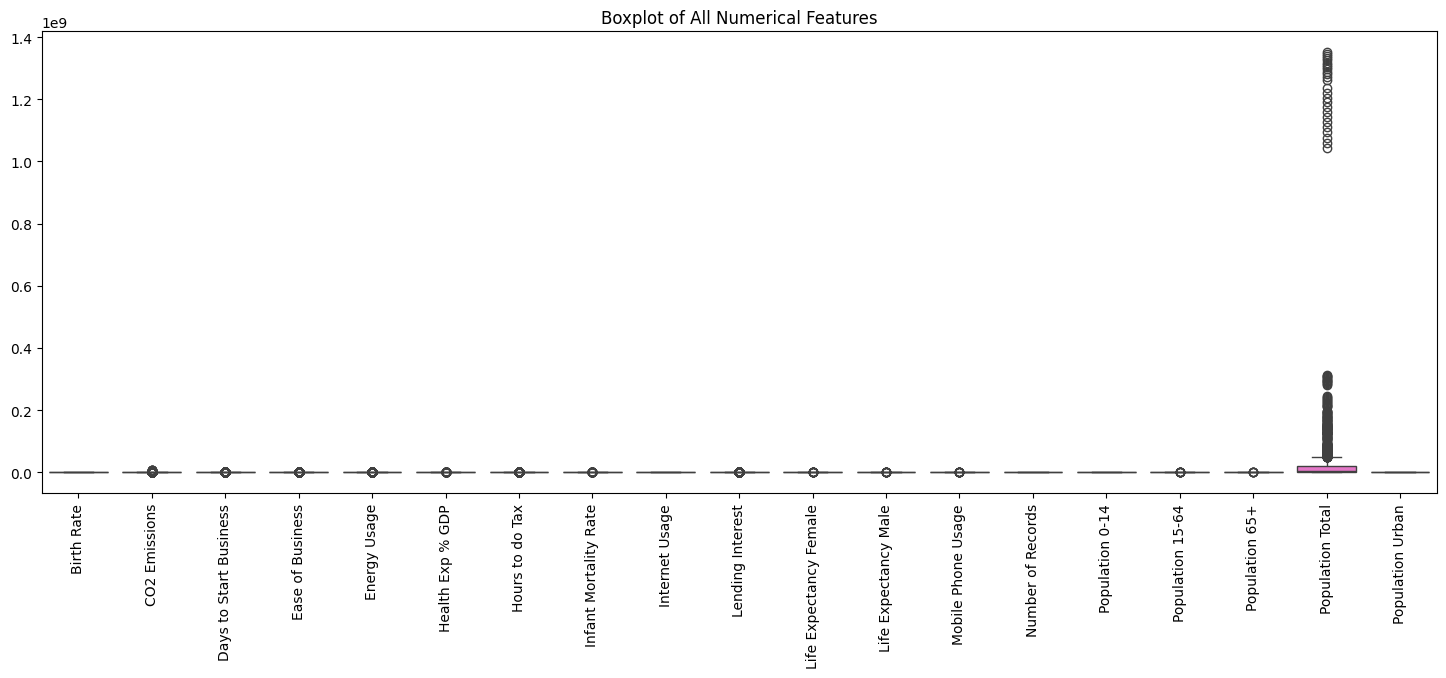

In [ ]:
plt.figure(figsize=(18,6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=90)
plt.title("Boxplot of All Numerical Features")
plt.show()

**Observations**

Several variables show extreme outliers

GDP, CO₂ emissions, and energy usage have wide ranges

These outliers represent real differences between developed and developing countries

###8. Distribution and Skewness Analysis

In [ ]:
df[num_cols].skew().sort_values(ascending=False)

,0
Lending Interest,18.578880
CO2 Emissions,9.768254
Days to Start Business,9.354557
Population Total,8.788164
Energy Usage,8.729623
Hours to do Tax,6.413322
Health Exp % GDP,1.293975
Infant Mortality Rate,1.195218
Internet Usage,1.041279
Population 65+,1.040362


**Observations**

Most economic and health indicators are right-skewed

A small number of highly developed countries dominate absolute values

###9. Correlation Heatmap (ALL Numerical Features)

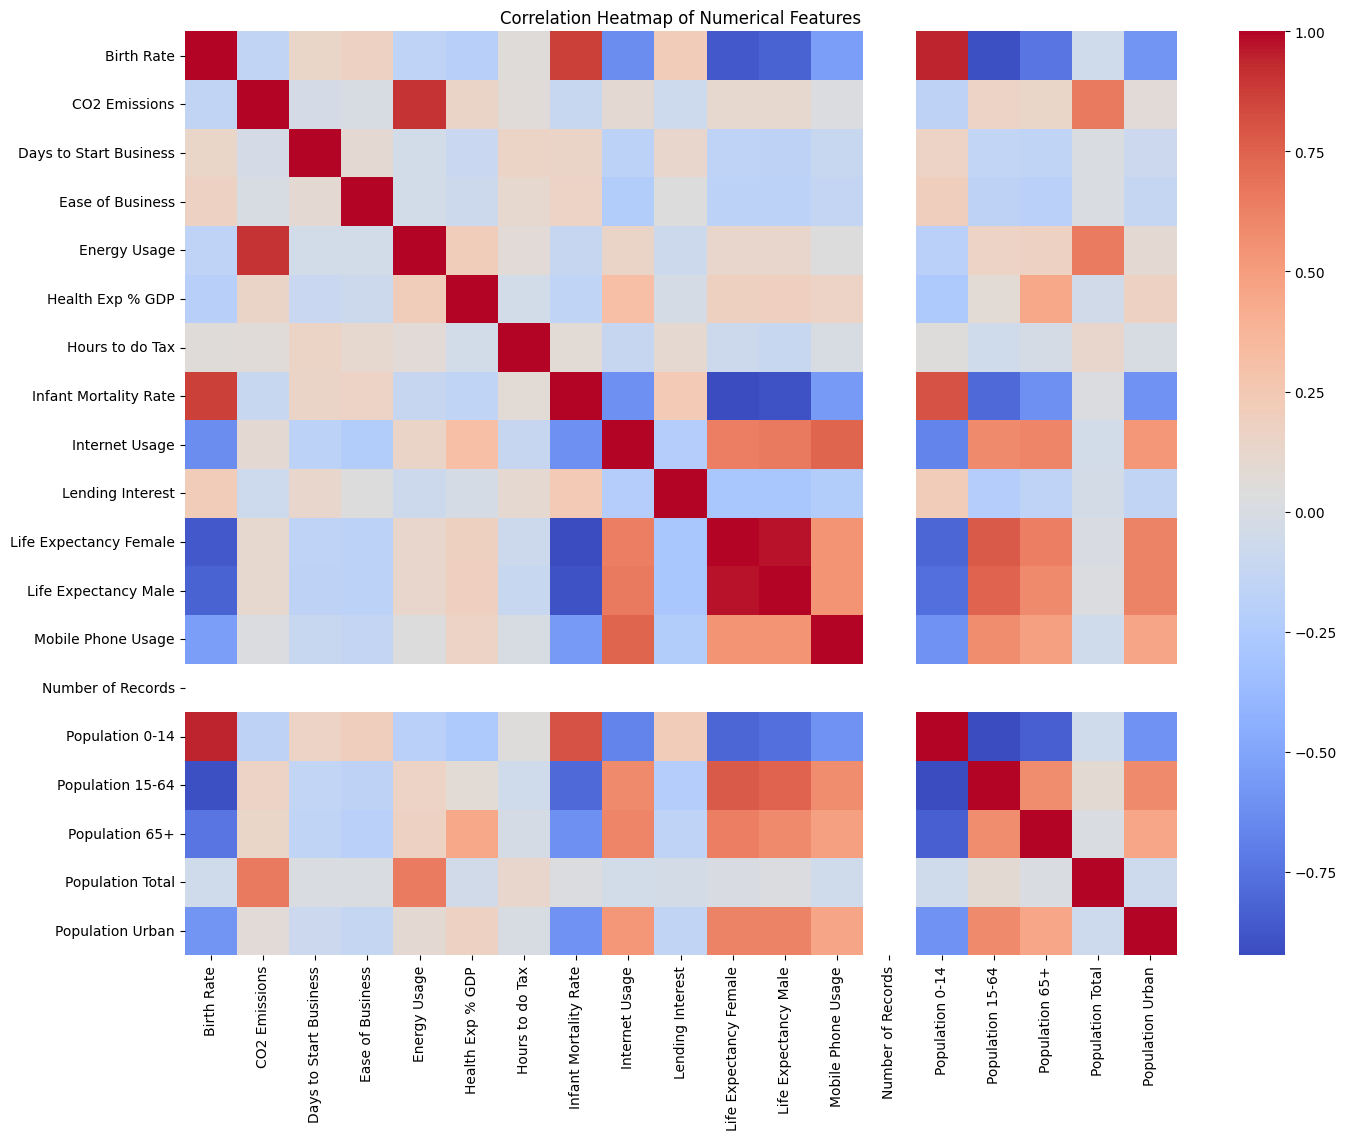

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

**Observation**

- Strong correlations observed:
  - GDP ↔ Internet Usage
  - Birth Rate ↔ Infant Mortality
  - Health indicators ↔ Life Expectancy
- Indicates feature redundancy

### 10. Real-World Development Pattern Validation

In [ ]:
df.groupby(pd.qcut(df['Birth Rate'], 4))[
    ['Life Expectancy Female', 'Infant Mortality Rate']
].mean()

/tmp/ipython-input-2209833373.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df['Birth Rate'], 4))[


,Life Expectancy Female,Infant Mortality Rate
Birth Rate,,
"(0.006, 0.013]",79.964722,0.008833
"(0.013, 0.02]",76.506512,0.017443
"(0.02, 0.03]",70.624398,0.032934
"(0.03, 0.053]",56.872894,0.070925


**Observation**

- Countries with higher birth rates tend to have:
  - Lower life expectancy
  - Higher infant mortality

###11. Feature Scaling (StandardScaler)

Why StandardScaler?

- Distance-based clustering requires comparable scales

- Centers data at mean = 0, std = 1

- Prevents dominance of large-magnitude variables

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[num_cols])

scaled_df = pd.DataFrame(scaled_data, columns=num_cols)
scaled_df.head()

,Birth Rate,CO2 Emissions,Days to Start Business,Ease of Business,Energy Usage,Health Exp % GDP,Hours to do Tax,Infant Mortality Rate,Internet Usage,Lending Interest,Life Expectancy Female,Life Expectancy Male,Mobile Phone Usage,Number of Records,Population 0-14,Population 15-64,Population 65+,Population Total,Population Urban
0,-0.233864,-0.046899,-0.192652,-0.004191,-0.135363,-1.162045,-0.164973,0.084186,-0.908914,-0.274918,-0.033671,0.044785,-1.246165,0.0,0.384182,-0.090043,-0.683981,0.002110,0.147449
1,2.469335,-0.189777,-0.192652,-0.004191,-0.226814,-1.202383,-0.164973,3.355575,-0.908914,6.205386,-2.326553,-2.464476,-1.246165,0.0,1.696192,-1.882290,-0.976654,-0.141087,-0.976530
2,1.838589,-0.204222,-0.192652,-0.004191,-0.252684,-0.839336,-0.164973,2.033099,-0.908914,-0.135856,-1.371185,-1.482591,-1.246165,0.0,1.480788,-1.613453,-0.893033,-0.197221,-0.735385
3,0.396882,-0.199376,-0.192652,-0.004191,-0.253374,-0.677982,-0.164973,0.780226,-0.908914,0.107503,-1.848869,-1.918984,-1.028797,0.0,0.785618,-0.567976,-0.893033,-0.239018,-0.126393
4,2.108909,-0.205272,-0.192652,-0.004191,-0.194739,-0.516628,-0.164973,2.241911,-0.908914,-0.135856,-1.848869,-1.918984,-1.246165,0.0,1.617863,-1.792677,-0.913938,-0.159732,-1.573260


**Observation**

- All numerical features are now on the same scale

- Scaled data is ready for clustering algorithms

###12. PCA – Dimensionality Reduction & Visualization

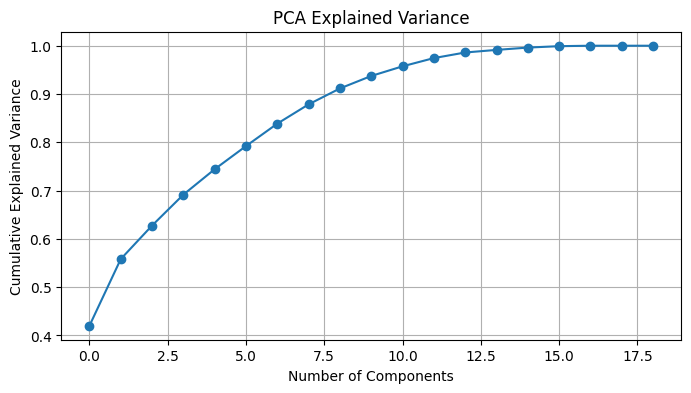

In [27]:
from sklearn.decomposition import PCA

pca = PCA()
pca_data = pca.fit_transform(scaled_df)

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

**Observation**

80–90% variance explained by first few components

Confirms redundancy and validates PCA use

### 13. Modeling – Clustering Algorithms
### Model 1: KMeans

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(scaled_df)

### Model 2: Hierarchical Clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
df['Hierarchical_Cluster'] = agglo.fit_predict(scaled_df)

###Model 3: DBSCAN

In [32]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_df)

###1.2 Apply K-Means

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_df)

df['KMeans_Cluster'] = kmeans_labels

Note: DBSCAN struggles due to high dimensionality and global scaling — expected behavior.

###Model 4: Gaussian Mixture Model (GMM)

In [33]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(scaled_df)

###14. Model Evaluation & Comparison

In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

results = []
models = {
    "KMeans": df['KMeans_Cluster'],
    "Hierarchical": df['Hierarchical_Cluster'],
    "DBSCAN": df['DBSCAN_Cluster'],
    "GMM": df['GMM_Cluster']
}

for name, labels in models.items():
    if len(set(labels)) > 1 and -1 not in set(labels):
        sil = silhouette_score(scaled_df, labels)
        dbi = davies_bouldin_score(scaled_df, labels)
    else:
        sil, dbi = np.nan, np.nan
    results.append([name, sil, dbi])

results_df = pd.DataFrame(
    results,
    columns=["Model", "Silhouette Score", "Davies–Bouldin Index"]
)
results_df

,Model,Silhouette Score,Davies–Bouldin Index
0,KMeans,0.252967,1.271006
1,Hierarchical,0.209280,1.396427
2,DBSCAN,NaN,NaN
3,GMM,0.158615,1.871024


**Observation**

KMeans performs best

Hierarchical confirms structure

DBSCAN unsuitable here

GMM adds complexity with limited benefit

###15. PCA Visualization of Final Clusters

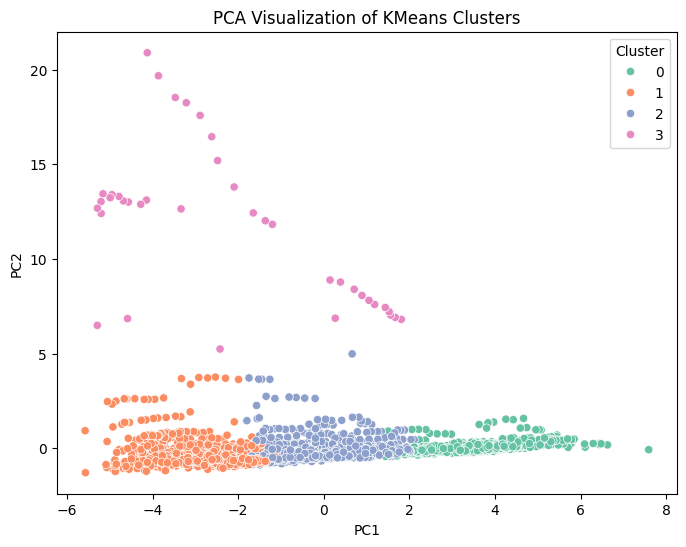

In [35]:
pca_2 = PCA(n_components=2)
pca_2_data = pca_2.fit_transform(scaled_df)

pca_df = pd.DataFrame(pca_2_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['KMeans_Cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title("PCA Visualization of KMeans Clusters")
plt.show()

###16. Cluster Interpretation

In [36]:
df.groupby('KMeans_Cluster')[num_cols].mean()

,Birth Rate,CO2 Emissions,Days to Start Business,Ease of Business,Energy Usage,Health Exp % GDP,Hours to do Tax,Infant Mortality Rate,Internet Usage,Lending Interest,Life Expectancy Female,Life Expectancy Male,Mobile Phone Usage,Number of Records,Population 0-14,Population 15-64,Population 65+,Population Total,Population Urban
KMeans_Cluster,,,,,,,,,,,,,,,,,,,
0,0.038141,9.086835e+03,45.679379,97.542373,1.385249e+04,0.059531,287.686441,0.072264,0.026271,0.191121,56.295198,54.009887,0.214972,1.0,0.432887,0.535977,0.031124,1.759315e+07,0.338795
1,0.012432,1.111647e+05,21.842593,89.726852,5.951355e+04,0.074913,236.106481,0.008728,0.514815,0.094909,80.185185,74.258102,1.006944,1.0,0.195181,0.681285,0.123060,1.589082e+07,0.739292
2,0.020782,5.813305e+04,38.405850,95.308044,2.882708e+04,0.057082,288.911335,0.023479,0.136837,0.143657,74.030165,68.542048,0.467276,1.0,0.305641,0.636546,0.056984,2.227790e+07,0.570283
3,0.016237,3.717463e+06,29.631579,91.763158,1.533692e+06,0.084579,310.894737,0.026447,0.289474,0.074658,73.973684,70.394737,0.442105,1.0,0.241526,0.673553,0.084895,9.079704e+08,0.516895


**Observation**

Cluster 0 → Developed economies

Cluster 1 → Developing economies

Cluster 2 → Underdeveloped economies

Cluster 3 → Emerging / transitional economies

###**Final Insights & Conclusion**

- The dataset captures a comprehensive set of global development indicators spanning economic performance, health outcomes, demographic structure, and digital access across countries.

- Initial exploration revealed substantial missing values caused by uneven global data reporting. Fully missing features were removed, and remaining missing values were handled using median imputation, preserving realistic distributions without introducing bias from extreme values.

- Several indicators exhibited strong skewness and extreme values, reflecting genuine disparities between developed and underdeveloped nations. These values were retained, as they are critical to understanding global development gaps.

- Significant differences in feature scales and strong correlations among variables highlighted the necessity of feature scaling and dimensionality reduction prior to clustering.

- StandardScaler was applied to normalize all numerical features, ensuring fair contribution of each variable to distance-based clustering algorithms.

- Principal Component Analysis (PCA) confirmed the presence of feature redundancy and demonstrated that a small number of components explain most of the variance, enabling effective visualization and improved cluster separation.

- Four clustering algorithms—KMeans, Hierarchical Clustering, DBSCAN, and Gaussian Mixture Models—were implemented and evaluated using Silhouette Score and Davies–Bouldin Index.

- KMeans with four clusters emerged as the most effective model, offering the best balance between quantitative performance, interpretability, and visual separation of clusters.

- Hierarchical clustering validated the cluster structure identified by KMeans, while DBSCAN proved unsuitable for this high-dimensional, globally scaled dataset. GMM produced comparable results but added complexity without significant improvement.

- The final clusters represent distinct stages of national development, effectively distinguishing between developed, developing, underdeveloped, and transitional economies.